In [29]:
import numpy as np # linear algebra
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly.graph_objects as go
import matplotlib.cm as cm
from matplotlib import rcParams
from PIL import Image
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import plotly.express as px
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler


%matplotlib inline
plt.style.use('ggplot')

In [30]:
filepath = 'data/TeePublic_review.csv'
df=pd.read_csv(filepath, encoding='latin1')

In [31]:
df.head()

,reviewer_id,store_location,latitude,longitude,date,month,year,title,review,review-label
0,0.0,US,37.090240,-95.712891,2023,6,2015 00:00:00,Great help with lost order,I had an order that was lost in transit. When ...,5
1,1.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,I ordered the wrong size tee and hadï¿½ï¿½ï¿½,I ordered the wrong size tee and had difficult...,5
2,2.0,US,37.090240,-95.712891,2023,6,2017 00:00:00,These guys offer the best customerï¿½ï¿½ï¿½,These guys offer the best customer service in ...,5
3,3.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,Good Stuff,Looked for an obscure phrase on a shirt. Teepu...,5
4,4.0,CA,56.130366,-106.346771,2023,6,2023 00:00:00,My order arrived in a good timelyï¿½ï¿½ï¿½,My order arrived in a good timely fashion & th...,4


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278100 entries, 0 to 278099
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewer_id     278099 non-null  float64
 1   store_location  278100 non-null  object 
 2   latitude        278100 non-null  float64
 3   longitude       278100 non-null  float64
 4   date            278100 non-null  int64  
 5   month           278100 non-null  int64  
 6   year            278100 non-null  object 
 7   title           278088 non-null  object 
 8   review          247597 non-null  object 
 9   review-label    278100 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 21.2+ MB


In [33]:
nulls = df.isnull()
duplicated_rows = df.duplicated()
df = df.copy()[~duplicated_rows]
df = df[['title', 'review', 'review-label']].copy()
new_columns = [column.replace('-', '_') for column in df.columns]
df.columns = new_columns
df_sentiment = df[~df.isnull().any(axis=1)]


In [34]:
# Undersampling technique to the df_sentiment dataset
n_samples = 10716
df_sentiment = df_sentiment.groupby('review_label').apply(lambda x: x.sample(n_samples)).reset_index(drop=True)
df_sentiment['review_label'] = df_sentiment['review_label'].map({1:0, 2:1, 3:2, 4:3, 5:4}) # Mapping the labels to 0-4, some ML models need this format

C:\Users\guilh\AppData\Local\Temp\ipykernel_39256\3968935714.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [35]:
fig1 = px.histogram(df, x='review_label', title='Distribution of Ratings')
fig1.show()

In [36]:
# Converting the 'review_label' column to integer type
df_sentiment['review_label'] = df_sentiment['review_label'].astype(int)

# Dataset into features (X) and target (y)
X = df_sentiment.drop('review_label', axis=1)
y = df_sentiment['review_label']

In [37]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove numbers, punctuation, and special characters
    text = re.sub(r'\d+', '', text)  
    text = re.sub(r'[^\w\s]', '', text) 
    text = text.lower()  
    return text

#  remove stopwords
def remove_stopwords(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

#  stemming and lemmatization functions
def apply_stemming(text):
    words = word_tokenize(text)
    words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

def apply_lemmatization(text):
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\guilh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\guilh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guilh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\guilh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [38]:
def preprocess_text(text):
    text = clean_text(text)
    text = remove_stopwords(text)
    text = apply_stemming(text)
    text = apply_lemmatization(text)
    return text

# Applying text preprocessing to the 'review' and 'title' columns
X['review'] = X['review'].apply(preprocess_text)
X['title'] = X['title'].apply(preprocess_text)

In [39]:
X.head()

,title,review
0,havent receiv tshirt ï½ï½ï½,havent receiv tshirt weekswent morn view order...
1,receiv order last week teeï½ï½ï½,receiv order last week tee shirt small sent em...
2,shirt receiv larg stainï½ï½ï½,shirt receiv larg stain watermark took larg po...
3,shrink way much,bought shirt birthday gift got smell almost li...
4,bought fat sal tee shirt theï½ï½ï½,bought fat sal tee shirt pictur fuzzi itï½ï½ï½...


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y) # stratify to keep the same distribution of the target variable

In [41]:
# Preprocessing steps
preprocess = ColumnTransformer(
    transformers=[
        ('text_review', TfidfVectorizer(), 'review'),    # vectorizing the 'review' column
        ('text_title', TfidfVectorizer(), 'title')
        ]
)

model = LogisticRegression(max_iter=1000)

# Creating the pipeline
pipeline = Pipeline([
    ('preprocess', preprocess), # Preprocessing
    ('classifier', model)       # Model
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text_review',
                                                  TfidfVectorizer(), 'review'),
                                                 ('text_title',
                                                  TfidfVectorizer(),
                                                  'title')])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [42]:
from joblib import dump

# Saving the model
dump(pipeline, 'models/pipeline-sentiment.joblib') 

['models/pipeline-sentiment.joblib']

In [43]:
predictions = pipeline.predict(X_test)

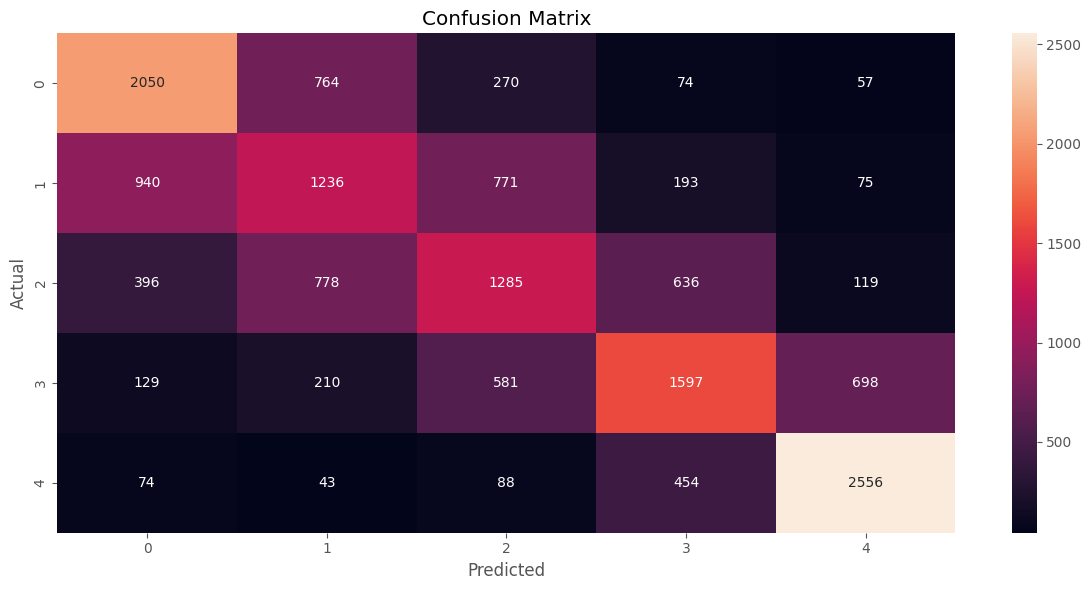

In [44]:
# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 6))

# Plotting Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', ax=ax1)
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [45]:
# Predictions on training set
train_predictions = pipeline.predict(X_train)

# Classification report for training set
train_report = classification_report(y_train, train_predictions)
print(f"Training Classification Report:\n{train_report}\n")

# Classification report for testing set
test_report = classification_report(y_test, predictions)
print(f"Testing Classification Report:\n{test_report}")

Training Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.77      7501
           1       0.70      0.67      0.68      7501
           2       0.69      0.65      0.67      7502
           3       0.74      0.70      0.72      7501
           4       0.82      0.89      0.85      7501

    accuracy                           0.74     37506
   macro avg       0.74      0.74      0.74     37506
weighted avg       0.74      0.74      0.74     37506


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.64      0.60      3215
           1       0.41      0.38      0.40      3215
           2       0.43      0.40      0.41      3214
           3       0.54      0.50      0.52      3215
           4       0.73      0.80      0.76      3215

    accuracy                           0.54     16074
   macro avg       0.54      0.54      0.54     16074
weighted avg 


Evaluating with 40.0% of the data for training...

Iteration 1 with train size 0.4: Accuracy = 53.28%
              precision    recall  f1-score   support

           0       0.57      0.61      0.59      5918
           1       0.40      0.40      0.40      5881
           2       0.41      0.37      0.39      5934
           3       0.53      0.50      0.51      5898
           4       0.72      0.79      0.75      5838

    accuracy                           0.53     29469
   macro avg       0.53      0.53      0.53     29469
weighted avg       0.53      0.53      0.53     29469

Iteration 2 with train size 0.4: Accuracy = 53.83%
              precision    recall  f1-score   support

           0       0.58      0.60      0.59      5960
           1       0.41      0.40      0.40      5877
           2       0.42      0.39      0.41      5909
           3       0.53      0.51      0.52      5811
           4       0.73      0.79      0.76      5912

    accuracy                   

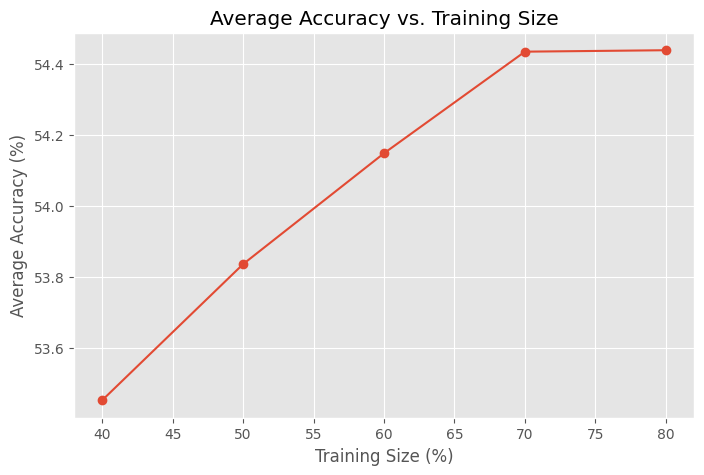

In [58]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# List of training sizes (fractions of the dataset to use for training)
train_sizes = [0.4, 0.5, 0.6, 0.7, 0.8]

# Number of iterations to retrain and evaluate
n_iterations = 5

# Store accuracy scores for each train size
accuracy_scores_by_size = {size: [] for size in train_sizes}
word_importances = {}

# Run multiple iterations with different train sizes
for train_size in train_sizes:
    print(f"\nEvaluating with {train_size*100}% of the data for training...\n")
    
    for i in range(n_iterations):
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=(1-train_size)-0.05, random_state=i)

        # Train the model
        pipeline.fit(X_train, y_train)

        # Make predictions
        y_pred = pipeline.predict(X_test)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores_by_size[train_size].append(accuracy)
        
        # Collect word importance 
        feature_names = pipeline[0].get_feature_names_out()
        coef = pipeline[1].coef_
        
        # Identify top words contributing to the classification
        for word, coef_value in zip(feature_names, coef.flatten()):
            if word not in word_importances:
                word_importances[word] = []
            word_importances[word].append(coef_value)

        # Print the classification report for each iteration
        print(f"Iteration {i + 1} with train size {train_size}: Accuracy = {accuracy * 100:.2f}%")
        print(classification_report(y_test, y_pred))

# Calculate the average accuracy for each training size
avg_accuracy_by_size = {size: np.mean(scores) for size, scores in accuracy_scores_by_size.items()}

# Display the average accuracy for each training size
print("\nAverage accuracy by training size:")
for size, avg_accuracy in avg_accuracy_by_size.items():
    print(f"Training size {size*100}%: {avg_accuracy * 100:.2f}%")

# Identify the average importance of each word
avg_word_importances = {word: np.mean(values) for word, values in word_importances.items()}

# Sort words by their importance
sorted_words = sorted(avg_word_importances.items(), key=lambda item: item[1], reverse=True)

# Display the top positive and negative words
top_n_words = 10
top_positive_words = [word for word, coef in sorted_words[-top_n_words:]]  # Positive sentiment
top_negative_words = [word for word, coef in sorted_words[:top_n_words]]  # Negative sentiment

print("\nTop positive words contributing to sentiment:")
for word in top_positive_words:
    print(f"{word}: {avg_word_importances[word]:.4f}")

print("\nTop negative words contributing to sentiment:")
for word in top_negative_words:
    print(f"{word}: {avg_word_importances[word]:.4f}")

# Plot the accuracy comparison
plt.figure(figsize=(8, 5))
plt.plot([size * 100 for size in train_sizes], [avg_accuracy_by_size[size] * 100 for size in train_sizes], marker='o')
plt.title("Average Accuracy vs. Training Size")
plt.xlabel("Training Size (%)")
plt.ylabel("Average Accuracy (%)")
plt.grid(True)
plt.show()


In [55]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Use CountVectorizer for LDA (instead of TF-IDF)
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X_counts = vectorizer.fit_transform(df_sentiment['review'])

# Apply LDA to identify topics
n_topics = 5  # Let's start with 5 topics
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_topics = lda_model.fit_transform(X_counts)

# Get the most important words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display the top words for each topic
no_top_words = 10
display_topics(lda_model, vectorizer.get_feature_names_out(), no_top_words)

# Assign the dominant topic to each review
dominant_topic = np.argmax(lda_topics, axis=1)
df_sentiment['topic'] = dominant_topic


Topic 1:
order customer service ordered received shipping shirt time days sent
Topic 2:
great shirts quality good shirt love shipping designs time delivery
Topic 3:
shirt quality print like shirts design ordered color looks disappointed
Topic 4:
½ï ½t ½s iï itï shirt ½m didnï ordered shirts
Topic 5:
size small shirt ordered large shirts fit like sizes medium


In [59]:
df_sentiment.head()

,title,review,review_label,topic
0,haven't received my t-shirts in 3ï¿½ï¿½ï¿½,haven't received my t-shirts in 3 weeks.Went o...,0,0
1,I received my order last week 6 teeï¿½ï¿½ï¿½,I received my order last week 6 tee shirts all...,0,3
2,Shirt was received with a large stainï¿½ï¿½ï¿½,Shirt was received with a large stain or water...,0,2
3,Shrink way to much!!,Bought 3 shirts for a birthday gift when I got...,0,4
4,I bought the fat Sal tee shirt and theï¿½ï¿½ï¿½,I bought the fat Sal tee shirt and the picture...,0,3


In [67]:
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Initialize a dictionary to store performance by topic
topic_performance = {}

# Loop through each topic and evaluate the classifier
for topic in range(n_topics):
    # Filter reviews belonging to this topic
    topic_data = df_sentiment[df_sentiment['topic'] == topic].copy()
    X_topic = topic_data.drop('review_label', axis=1).copy()
    y_topic = topic_data['review_label'].copy()
    
    # Verifica se há dados suficientes para treino e teste
    if len(topic_data) < 2:
        print(f"Topic {topic} skipped due to insufficient data.")
        continue
    
    try:
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_topic, y_topic, test_size=0.2, random_state=42)

        # Re-treine o pipeline com os dados filtrados (texto bruto)
        pipeline.fit(X_train, y_train)
        
        # Faça as previsões usando o pipeline completo
        y_pred = pipeline.predict(X_test)
        
        # Calculate accuracy and report for this topic
        accuracy = balanced_accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        
        # Store the results
        topic_performance[topic] = {
            'accuracy': accuracy,
            'classification_report': report
        }
        
        # Print performance for each topic
        print(f"Topic {topic + 1}:")
        print(f"Accuracy: {accuracy * 100:.2f}%")
        print(report)

    except IndexError as e:
        print(f"Error processing topic {topic}: {e}")

# Check overall topic performance
topic_performance


Topic 1:
Accuracy: 49.41%
              precision    recall  f1-score   support

           0       0.62      0.82      0.71       746
           1       0.38      0.27      0.31       442
           2       0.33      0.27      0.29       320
           3       0.50      0.41      0.45       309
           4       0.70      0.70      0.70       279

    accuracy                           0.54      2096
   macro avg       0.51      0.49      0.49      2096
weighted avg       0.52      0.54      0.52      2096

Topic 2:
Accuracy: 39.76%
              precision    recall  f1-score   support

           0       1.00      0.08      0.14        53
           1       0.41      0.15      0.22        88
           2       0.41      0.29      0.34       240
           3       0.62      0.56      0.59       815
           4       0.78      0.91      0.84      1482

    accuracy                           0.71      2678
   macro avg       0.64      0.40      0.43      2678
weighted avg       0.69  

{0: {'accuracy': 0.494127812910362,
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.62      0.82      0.71       746\n           1       0.38      0.27      0.31       442\n           2       0.33      0.27      0.29       320\n           3       0.50      0.41      0.45       309\n           4       0.70      0.70      0.70       279\n\n    accuracy                           0.54      2096\n   macro avg       0.51      0.49      0.49      2096\nweighted avg       0.52      0.54      0.52      2096\n'},
 1: {'accuracy': 0.39763882962838437,
  'classification_report': '              precision    recall  f1-score   support\n\n           0       1.00      0.08      0.14        53\n           1       0.41      0.15      0.22        88\n           2       0.41      0.29      0.34       240\n           3       0.62      0.56      0.59       815\n           4       0.78      0.91      0.84      1482\n\n    accuracy                     

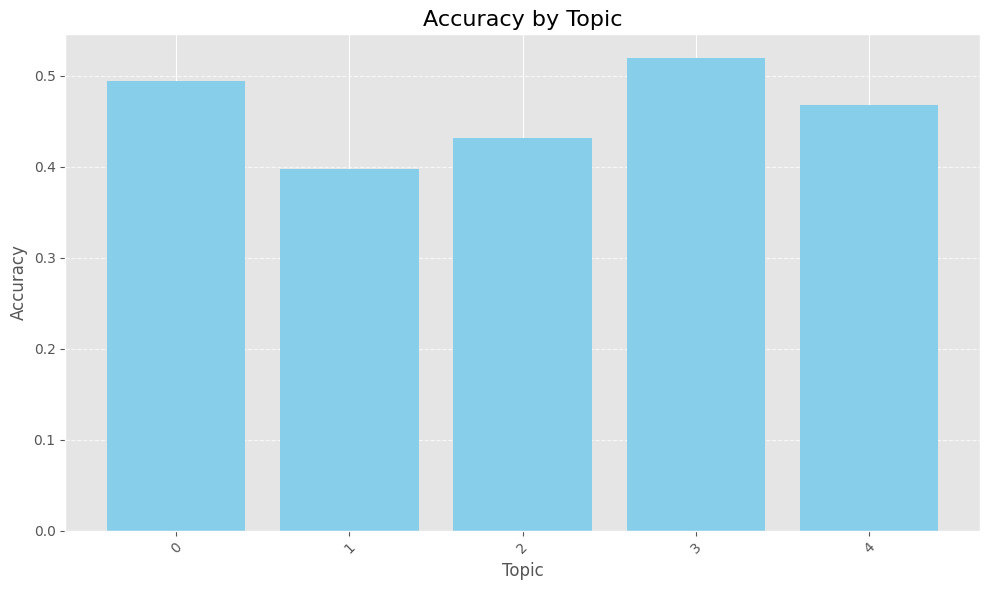

In [86]:
import matplotlib.pyplot as plt

# Extrair os tópicos e suas respectivas acurácias do dicionário topic_performance
topics = list(topic_performance.keys())
accuracies = [topic_performance[topic]['accuracy'] for topic in topics]

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(topics, accuracies, color='skyblue')

# Adicionar títulos e rótulos
plt.title('Accuracy by Topic', fontsize=16)
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Mostrar o gráfico
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
